<a href="https://colab.research.google.com/github/LiQuinChing/25-26J-522/blob/Vihara/modelARRNSR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ============================================================
# Hybrid 2D-CNN + LSTM (Leak-proof patient split) for ARR vs NSR
# - Uses your folder structure: class_dir / recording_folder / 0.png..9.png
# - Groups by patient ID so "SecondLead" stays in same split
# - Selects 30 patients from ARR and 30 from NSR (if available)
# - Splits 70/15/15 by PATIENT (no leakage)
# - Lightweight CNN->GAP->LSTM model to reduce overfitting
# - Prints model summary
# - Confusion matrix + classification report (on TEST set by default)
# ============================================================

import os, re, random
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# -------------------------
# 0) Reproducibility
# -------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [ ]:
# -------------------------
# 1) Paths
# -------------------------
base_dir = "/content/drive/MyDrive/ECG_Images/ECG_matlab_images"
arr_base = os.path.join(base_dir, "MATLAB_arrhythmia")
nsr_base = os.path.join(base_dir, "MATLAB_normal")

In [ ]:
# -------------------------
# 2) Constants
# -------------------------
IMG_H, IMG_W = 227, 227
SEQ_LEN = 10
NUM_CLASSES = 2
IMG_EXTS = (".png", ".jpg", ".jpeg")

In [ ]:
# -------------------------
# 3) Helpers
# -------------------------
def is_image_file(p: str) -> bool:
    return p.lower().endswith(IMG_EXTS)

def extract_patient_id(folder_name: str, class_type: str) -> str:
    """
    Extract patient/record ID based on your folder naming conventions.

    ARR example: 100_MLII_segments -> "100"
    NSR examples: TenSegof19090 -> "19090"
                  TenSegof19090SecondLead -> "19090"

    Returns a string patient ID.
    """
    name = folder_name.lower()

    if class_type == "arr":
        # take leading digits before underscore if present; fallback to first digits anywhere
        m = re.match(r"(\d+)", folder_name)
        if m:
            return m.group(1)
        nums = re.findall(r"\d+", folder_name)
        return nums[0] if nums else folder_name

    # nsr
    # capture digits after "tensegof"
    m = re.search(r"tensegof(\d+)", name)
    if m:
        return m.group(1)
    # fallback: first number in name
    nums = re.findall(r"\d+", folder_name)
    return nums[0] if nums else folder_name

def load_sequence_from_folder(folder_path: str, seq_len: int = 10) -> list:
    """
    Loads a sequence as a LIST OF IMAGE PATHS (length seq_len) from one recording folder.
    Assumes file names are 0.png..9.png (or at least numeric stem).
    """
    imgs = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if is_image_file(f)]
    if len(imgs) < seq_len:
        return None

    # Sort by numeric filename: "0.png" -> 0, "9.png" -> 9
    def num_key(p):
        stem = os.path.splitext(os.path.basename(p))[0]
        m = re.findall(r"\d+", stem)
        return int(m[0]) if m else 10**9

    imgs.sort(key=num_key)
    seq = imgs[:seq_len]
    return seq if len(seq) == seq_len else None

def build_patient_groups(class_root: str, class_type: str, seq_len: int = 10):
    """
    Returns:
      patient_to_seqs: dict patient_id -> list of sequences (each sequence = list of image paths)
    Note: If a patient has 2 leads saved as 2 folders, we will store TWO sequences under same patient.
    """
    patient_to_seqs = {}
    subdirs = [d for d in os.listdir(class_root) if os.path.isdir(os.path.join(class_root, d))]
    subdirs.sort()

    for d in subdirs:
        pid = extract_patient_id(d, class_type)
        folder_path = os.path.join(class_root, d)
        seq = load_sequence_from_folder(folder_path, seq_len=seq_len)
        if seq is None:
            continue
        patient_to_seqs.setdefault(pid, []).append(seq)

    return patient_to_seqs

def choose_n_patients(patient_to_seqs: dict, n_patients: int):
    """
    Randomly choose n_patients (patient IDs). Returns reduced dict.
    """
    pids = list(patient_to_seqs.keys())
    random.shuffle(pids)
    chosen = pids[:min(n_patients, len(pids))]
    return {pid: patient_to_seqs[pid] for pid in chosen}

def split_patients(patient_ids: list, train_ratio=0.70, val_ratio=0.15, test_ratio=0.15):
    """
    Split patient IDs (not sequences!) into train/val/test.
    """
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6

    patient_ids = list(patient_ids)
    random.shuffle(patient_ids)

    n = len(patient_ids)
    n_train = int(train_ratio * n)
    n_val = int(val_ratio * n)

    train_ids = patient_ids[:n_train]
    val_ids = patient_ids[n_train:n_train + n_val]
    test_ids = patient_ids[n_train + n_val:]

    return train_ids, val_ids, test_ids

def flatten_patient_dict(patient_to_seqs: dict, patient_id_list: list, label: int):
    """
    From patient_to_seqs and a list of patient IDs, return:
      X: list of sequences (each seq = list of 10 paths)
      y: list of int labels aligned to X
    Important: If a patient has 2 sequences (two leads), both go to same split.
    """
    X, y = [], []
    for pid in patient_id_list:
        seqs = patient_to_seqs.get(pid, [])
        for seq in seqs:
            X.append(seq)
            y.append(label)
    return X, y

In [ ]:
# -------------------------
# 4) Build patient groups (leak-proof)
# -------------------------
arr_patient_to_seqs = build_patient_groups(arr_base, "arr", seq_len=SEQ_LEN)
nsr_patient_to_seqs = build_patient_groups(nsr_base, "nsr", seq_len=SEQ_LEN)

print("ARR patients found:", len(arr_patient_to_seqs))
print("NSR patients found:", len(nsr_patient_to_seqs))

# Select 30 patients each (as you requested)
N_PER_CLASS_PATIENTS = 30
arr_patient_to_seqs = choose_n_patients(arr_patient_to_seqs, N_PER_CLASS_PATIENTS)
nsr_patient_to_seqs = choose_n_patients(nsr_patient_to_seqs, N_PER_CLASS_PATIENTS)

print("ARR patients used:", len(arr_patient_to_seqs))
print("NSR patients used:", len(nsr_patient_to_seqs))

ARR patients found: 48
NSR patients found: 18
ARR patients used: 30
NSR patients used: 18


In [ ]:
# -------------------------
# 5) Split by patient IDs (70/15/15) - NO LEAKAGE
# -------------------------
arr_pids = list(arr_patient_to_seqs.keys())
nsr_pids = list(nsr_patient_to_seqs.keys())

arr_train_ids, arr_val_ids, arr_test_ids = split_patients(arr_pids, 0.70, 0.15, 0.15)
nsr_train_ids, nsr_val_ids, nsr_test_ids = split_patients(nsr_pids, 0.70, 0.15, 0.15)

X_train_arr, y_train_arr = flatten_patient_dict(arr_patient_to_seqs, arr_train_ids, label=1)
X_val_arr,   y_val_arr   = flatten_patient_dict(arr_patient_to_seqs, arr_val_ids,   label=1)
X_test_arr,  y_test_arr  = flatten_patient_dict(arr_patient_to_seqs, arr_test_ids,  label=1)

X_train_nsr, y_train_nsr = flatten_patient_dict(nsr_patient_to_seqs, nsr_train_ids, label=0)
X_val_nsr,   y_val_nsr   = flatten_patient_dict(nsr_patient_to_seqs, nsr_val_ids,   label=0)
X_test_nsr,  y_test_nsr  = flatten_patient_dict(nsr_patient_to_seqs, nsr_test_ids,  label=0)

X_train = X_train_arr + X_train_nsr
y_train = y_train_arr + y_train_nsr
X_val   = X_val_arr   + X_val_nsr
y_val   = y_val_arr   + y_val_nsr
X_test  = X_test_arr  + X_test_nsr
y_test  = y_test_arr  + y_test_nsr

# Shuffle within each split
def shuffle_split(X, y):
    combined = list(zip(X, y))
    random.shuffle(combined)
    X, y = zip(*combined) if combined else ([], [])
    return list(X), np.array(list(y), dtype=np.int32)

X_train, y_train = shuffle_split(X_train, y_train)
X_val,   y_val   = shuffle_split(X_val, y_val)
X_test,  y_test  = shuffle_split(X_test, y_test)

print("\nSequences (samples) after split:")
print("Train sequences:", len(X_train))
print("Val sequences:",   len(X_val))
print("Test sequences:",  len(X_test))


Sequences (samples) after split:
Train sequences: 45
Val sequences: 8
Test sequences: 13


In [ ]:
# -------------------------
# 6) tf.data pipeline (sequence -> tensor [T,H,W,3])
# -------------------------
AUTOTUNE = tf.data.AUTOTUNE

def decode_and_resize(img_bytes):
    img = tf.image.decode_image(img_bytes, channels=3, expand_animations=False)
    img = tf.image.resize(img, (IMG_H, IMG_W))
    img = tf.cast(img, tf.float32) / 255.0
    return img

def load_sequence(seq_paths, label):
    imgs = tf.map_fn(
        lambda p: decode_and_resize(tf.io.read_file(p)),
        seq_paths,
        fn_output_signature=tf.float32
    )
    # one-hot for categorical_crossentropy
    label_onehot = tf.one_hot(label, depth=NUM_CLASSES)
    return imgs, label_onehot

def make_dataset(X_seqs, y_labels, batch_size=8, shuffle=True):
    X_arr = tf.constant(X_seqs)  # shape [N, T]
    y_arr = tf.constant(y_labels)
    ds = tf.data.Dataset.from_tensor_slices((X_arr, y_arr))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(X_seqs), reshuffle_each_iteration=True, seed=SEED)
    ds = ds.map(load_sequence, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

BATCH_SIZE = 8
train_ds = make_dataset(X_train, y_train, batch_size=BATCH_SIZE, shuffle=True)
val_ds   = make_dataset(X_val,   y_val,   batch_size=BATCH_SIZE, shuffle=False)
test_ds  = make_dataset(X_test,  y_test,  batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
# -------------------------
# 7) Lightweight Hybrid Model (CNN -> GAP -> LSTM)
# -------------------------
def build_small_hybrid(seq_len=10, img_h=227, img_w=227, channels=3,
                       lstm_units=32, dropout=0.5, l2=1e-4):
    inp = tf.keras.Input(shape=(seq_len, img_h, img_w, channels), name="sequence_input")

    x = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Conv2D(32, (3,3), padding="same",
                               kernel_regularizer=tf.keras.regularizers.l2(l2)),
        name="td_conv32"
    )(inp)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization(), name="td_bn1")(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.ReLU(), name="td_relu1")(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2,2)), name="td_pool1")(x)

    x = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Conv2D(64, (3,3), padding="same",
                               kernel_regularizer=tf.keras.regularizers.l2(l2)),
        name="td_conv64"
    )(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization(), name="td_bn2")(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.ReLU(), name="td_relu2")(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2,2)), name="td_pool2")(x)

    x = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Conv2D(128, (3,3), padding="same",
                               kernel_regularizer=tf.keras.regularizers.l2(l2)),
        name="td_conv128"
    )(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization(), name="td_bn3")(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.ReLU(), name="td_relu3")(x)

    # Key overfitting reducer: GAP instead of Flatten
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.GlobalAveragePooling2D(),
                                        name="td_gap")(x)

    x = tf.keras.layers.LSTM(lstm_units,
                             dropout=0.2,
                             recurrent_dropout=0.2,
                             name="lstm")(x)

    x = tf.keras.layers.Dense(128, activation="relu",
                              kernel_regularizer=tf.keras.regularizers.l2(l2),
                              name="dense_128")(x)
    x = tf.keras.layers.Dropout(dropout, name="dropout")(x)

    out = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="softmax_out")(x)
    return tf.keras.Model(inp, out, name="Small_2DCNN_LSTM_ARR_NSR")

model = build_small_hybrid(seq_len=SEQ_LEN, img_h=IMG_H, img_w=IMG_W, channels=3,
                           lstm_units=32, dropout=0.5, l2=1e-4)

# Model summary (as requested)
model.summary()

Model: "Small_2DCNN_LSTM_ARR_NSR"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequence_input (InputLayer)     │ (None, 10, 227, 227,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_conv32 (TimeDistributed)     │ (None, 10, 227, 227,   │           896 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_bn1 (TimeDistributed)        │ (None, 10, 227, 227,   │           128 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_relu1 (TimeDistributed)      │ (None, 10, 227, 227,   │             0 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_pool1 (TimeDistributed)      │ (None, 10, 113, 113,   │             0 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_conv64 (TimeDistributed)     │ (None, 10, 113, 113,   │        18,496 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_bn2 (TimeDistributed)        │ (None, 10, 113, 113,   │           256 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_relu2 (TimeDistributed)      │ (None, 10, 113, 113,   │             0 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_pool2 (TimeDistributed)      │ (None, 10, 56, 56, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_conv128 (TimeDistributed)    │ (None, 10, 56, 56,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_bn3 (TimeDistributed)        │ (None, 10, 56, 56,     │           512 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_relu3 (TimeDistributed)      │ (None, 10, 56, 56,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_gap (TimeDistributed)        │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_out (Dense)             │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,234 (465.76 KB)

 Trainable params: 118,786 (464.01 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# -------------------------
# 8) Compile + Train
# -------------------------
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=loss_fn,
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=8,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 325s 47s/step - accuracy: 0.5329 - auc: 0.6119 - loss: 0.6929 - val_accuracy: 0.5000 - val_auc: 0.4375 - val_loss: 0.7200 - learning_rate: 1.0000e-04
Epoch 2/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 268s 44s/step - accuracy: 0.6096 - auc: 0.5307 - loss: 0.7164 - val_accuracy: 0.5000 - val_auc: 0.6875 - val_loss: 0.7179 - learning_rate: 1.0000e-04
Epoch 3/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 268s 44s/step - accuracy: 0.7050 - auc: 0.7675 - loss: 0.6265 - val_accuracy: 0.5000 - val_auc: 0.7344 - val_loss: 0.7003 - learning_rate: 1.0000e-04
Epoch 4/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 263s 43s/step - accuracy: 0.8113 - auc: 0.8961 - loss: 0.5800 - val_accuracy: 0.5000 - val_auc: 0.7500 - val_loss: 0.6802 - learning_rate: 1.0000e-04
Epoch 5/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 331s 45s/step - accuracy: 0.7671 - auc: 0.8334 - loss: 0.5925 - val_accuracy: 0.8750 - val_auc: 0.9922 - val_loss: 0.6542 - learning_rate: 1.0000e-04
Epoch 6/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 316s 44s/step - accuracy: 0.7735 -

In [ ]:
# -------------------------
# 9) Evaluate + Confusion Matrix (TEST set is best practice)
# -------------------------
print("\n=== TEST EVALUATION ===")
test_results = model.evaluate(test_ds, verbose=1)
print(dict(zip(model.metrics_names, test_results)))

# Predict on test set (recording-level: 1 prediction per sequence/recording-folder)
y_prob = model.predict(test_ds)
y_pred = np.argmax(y_prob, axis=1)

# True labels (convert one-hot labels from y_test which we stored as ints already)
y_true = y_test

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix (TEST) [rows=true, cols=pred]:")
print(cm)

print("\nClassification Report (TEST):")
print(classification_report(y_true, y_pred, target_names=["NSR", "ARR"]))

# If you ALSO want confusion matrix for VAL (optional)
print("\n=== VAL CONFUSION MATRIX (optional check) ===")
y_prob_val = model.predict(val_ds)
y_pred_val = np.argmax(y_prob_val, axis=1)
cm_val = confusion_matrix(y_val, y_pred_val)
print("Confusion Matrix (VAL) [rows=true, cols=pred]:")
print(cm_val)
print("\nClassification Report (VAL):")
print(classification_report(y_val, y_pred_val, target_names=["NSR", "ARR"]))


=== TEST EVALUATION ===
2/2 ━━━━━━━━━━━━━━━━━━━━ 23s 7s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.2646
{'loss': 0.26648232340812683, 'compile_metrics': 1.0}
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step

Confusion Matrix (TEST) [rows=true, cols=pred]:
[[8 0]
 [0 5]]

Classification Report (TEST):
              precision    recall  f1-score   support

         NSR       1.00      1.00      1.00         8
         ARR       1.00      1.00      1.00         5

    accuracy                           1.00        13
   macro avg       1.00      1.00      1.00        13
weighted avg       1.00      1.00      1.00        13


=== VAL CONFUSION MATRIX (optional check) ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Confusion Matrix (VAL) [rows=true, cols=pred]:
[[4 0]
 [0 4]]

Classification Report (VAL):
              precision    recall  f1-score   support

         NSR       1.00      1.00      1.00         4
         ARR       1.00      1.00      1.00         4

    accuracy                          

In [ ]:
# =========================
# 10) Final Evaluation (Test set)
# =========================
results = model.evaluate(test_ds, verbose=1)
print("Test results:", dict(zip(model.metrics_names, results)))

# =========================
# 11) Save the trained model
# =========================
MODEL_SAVE_PATH = "/content/drive/MyDrive/ECG_Images/small_2dcnn_lstm_arr_nsr.keras"

model.save(MODEL_SAVE_PATH)
print(f"Model saved to: {MODEL_SAVE_PATH}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.2646
Test results: {'loss': 0.26648232340812683, 'compile_metrics': 1.0}
Model saved to: /content/drive/MyDrive/ECG_Images/small_2dcnn_lstm_arr_nsr.keras


In [ ]:
# ============================================================
# A) TEST RESULTS + CONFUSION MATRIX (for your recent model)
#    - Uses the split test_ds you already created
#    - Gives accuracy, AUC, loss
#    - Confusion matrix + classification report
#    - Also prints per-class accuracy
# ============================================================

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

print("\n=== TEST EVALUATION (unseen split) ===")
test_results = model.evaluate(test_ds, verbose=1)
print("Test results:", dict(zip(model.metrics_names, test_results)))

# Predict probabilities on the unseen test split
y_prob_test = model.predict(test_ds, verbose=1)
y_pred_test = np.argmax(y_prob_test, axis=1)

# True labels are the integer labels you created during split
# (y_test is your numpy array with 0=NSR, 1=ARR)
y_true_test = y_test

# Confusion matrix
cm = confusion_matrix(y_true_test, y_pred_test)
print("\nConfusion Matrix (TEST) [rows=true, cols=pred] (0=NSR, 1=ARR):")
print(cm)

# Classification report
print("\nClassification Report (TEST):")
print(classification_report(y_true_test, y_pred_test, target_names=["NSR", "ARR"]))

# Overall accuracy (sanity check)
acc = accuracy_score(y_true_test, y_pred_test)
print("Overall Test Accuracy:", acc)

# Per-class accuracy
# cm:
# [[TN FP],
#  [FN TP]]
tn, fp, fn, tp = cm.ravel()
nsr_acc = tn / (tn + fp) if (tn + fp) else 0.0
arr_acc = tp / (tp + fn) if (tp + fn) else 0.0
print(f"Per-class accuracy: NSR={nsr_acc:.4f}, ARR={arr_acc:.4f}")


In [5]:
import os, re, random
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# =========================
# 0) Set seed (MUST match the training seed you used)
# =========================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# =========================
# 1) Load the saved model
# =========================
MODEL_SAVE_PATH = "/content/drive/MyDrive/ECG_Images/small_2dcnn_lstm_arr_nsr.keras"
model = tf.keras.models.load_model(MODEL_SAVE_PATH)
print("Loaded model from:", MODEL_SAVE_PATH)
model.summary()

# =========================
# 2) Paths (same as before)
# =========================
base_dir = "/content/drive/MyDrive/ECG_Images/ECG_matlab_images"
arr_base = os.path.join(base_dir, "MATLAB_arrhythmia")
nsr_base = os.path.join(base_dir, "MATLAB_normal")

# =========================
# 3) Constants (same as before)
# =========================
IMG_H, IMG_W = 227, 227
SEQ_LEN = 10
NUM_CLASSES = 2
IMG_EXTS = (".png", ".jpg", ".jpeg")

# =========================
# 4) Helper functions (same as before)
# =========================
def is_image_file(p: str) -> bool:
    return p.lower().endswith(IMG_EXTS)

def extract_patient_id(folder_name: str, class_type: str) -> str:
    name = folder_name.lower()
    if class_type == "arr":
        m = re.match(r"(\d+)", folder_name)
        if m:
            return m.group(1)
        nums = re.findall(r"\d+", folder_name)
        return nums[0] if nums else folder_name
    # nsr
    m = re.search(r"tensegof(\d+)", name)
    if m:
        return m.group(1)
    nums = re.findall(r"\d+", folder_name)
    return nums[0] if nums else folder_name

def load_sequence_from_folder(folder_path: str, seq_len: int = 10) -> list:
    imgs = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if is_image_file(f)]
    if len(imgs) < seq_len:
        return None

    def num_key(p):
        stem = os.path.splitext(os.path.basename(p))[0]
        m = re.findall(r"\d+", stem)
        return int(m[0]) if m else 10**9

    imgs.sort(key=num_key)
    seq = imgs[:seq_len]
    return seq if len(seq) == seq_len else None

def build_patient_groups(class_root: str, class_type: str, seq_len: int = 10):
    patient_to_seqs = {}
    subdirs = [d for d in os.listdir(class_root) if os.path.isdir(os.path.join(class_root, d))]
    subdirs.sort()
    for d in subdirs:
        pid = extract_patient_id(d, class_type)
        folder_path = os.path.join(class_root, d)
        seq = load_sequence_from_folder(folder_path, seq_len=seq_len)
        if seq is None:
            continue
        patient_to_seqs.setdefault(pid, []).append(seq)
    return patient_to_seqs

def choose_n_patients(patient_to_seqs: dict, n_patients: int):
    pids = list(patient_to_seqs.keys())
    random.shuffle(pids)
    chosen = pids[:min(n_patients, len(pids))]
    return {pid: patient_to_seqs[pid] for pid in chosen}

def split_patients(patient_ids: list, train_ratio=0.70, val_ratio=0.15, test_ratio=0.15):
    patient_ids = list(patient_ids)
    random.shuffle(patient_ids)
    n = len(patient_ids)
    n_train = int(train_ratio * n)
    n_val = int(val_ratio * n)
    train_ids = patient_ids[:n_train]
    val_ids = patient_ids[n_train:n_train + n_val]
    test_ids = patient_ids[n_train + n_val:]
    return train_ids, val_ids, test_ids

def flatten_patient_dict(patient_to_seqs: dict, patient_id_list: list, label: int):
    X, y = [], []
    for pid in patient_id_list:
        seqs = patient_to_seqs.get(pid, [])
        for seq in seqs:
            X.append(seq)
            y.append(label)
    return X, y

def shuffle_split(X, y):
    combined = list(zip(X, y))
    random.shuffle(combined)
    X, y = zip(*combined) if combined else ([], [])
    return list(X), np.array(list(y), dtype=np.int32)

# =========================
# 5) Rebuild the SAME test split
# IMPORTANT: This only matches exactly if:
#   - same SEED
#   - same N_PER_CLASS_PATIENTS
#   - same folders present
# =========================
N_PER_CLASS_PATIENTS = 30

arr_patient_to_seqs = build_patient_groups(arr_base, "arr", seq_len=SEQ_LEN)
nsr_patient_to_seqs = build_patient_groups(nsr_base, "nsr", seq_len=SEQ_LEN)

arr_patient_to_seqs = choose_n_patients(arr_patient_to_seqs, N_PER_CLASS_PATIENTS)
nsr_patient_to_seqs = choose_n_patients(nsr_patient_to_seqs, N_PER_CLASS_PATIENTS)

arr_pids = list(arr_patient_to_seqs.keys())
nsr_pids = list(nsr_patient_to_seqs.keys())

arr_train_ids, arr_val_ids, arr_test_ids = split_patients(arr_pids, 0.70, 0.15, 0.15)
nsr_train_ids, nsr_val_ids, nsr_test_ids = split_patients(nsr_pids, 0.70, 0.15, 0.15)

# We only need TEST here
X_test_arr, y_test_arr = flatten_patient_dict(arr_patient_to_seqs, arr_test_ids, label=1)
X_test_nsr, y_test_nsr = flatten_patient_dict(nsr_patient_to_seqs, nsr_test_ids, label=0)

X_test = X_test_arr + X_test_nsr
y_test = y_test_arr + y_test_nsr
X_test, y_test = shuffle_split(X_test, y_test)

print("Rebuilt TEST sequences:", len(X_test))

# =========================
# 6) Build the SAME tf.data test pipeline
# =========================
AUTOTUNE = tf.data.AUTOTUNE

def decode_and_resize(img_bytes):
    img = tf.image.decode_image(img_bytes, channels=3, expand_animations=False)
    img = tf.image.resize(img, (IMG_H, IMG_W))
    img = tf.cast(img, tf.float32) / 255.0
    return img

def load_sequence(seq_paths, label):
    imgs = tf.map_fn(
        lambda p: decode_and_resize(tf.io.read_file(p)),
        seq_paths,
        fn_output_signature=tf.float32
    )
    label_onehot = tf.one_hot(label, depth=NUM_CLASSES)
    return imgs, label_onehot

def make_dataset(X_seqs, y_labels, batch_size=8):
    X_arr = tf.constant(X_seqs)
    y_arr = tf.constant(y_labels)
    ds = tf.data.Dataset.from_tensor_slices((X_arr, y_arr))
    ds = ds.map(load_sequence, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

test_ds = make_dataset(X_test, y_test, batch_size=8)

# =========================
# 7) Evaluate + Confusion Matrix
# =========================
print("\n=== TEST EVALUATION (loaded model, unseen split) ===")
results = model.evaluate(test_ds, verbose=1)
print("Test results:", dict(zip(model.metrics_names, results)))

y_prob = model.predict(test_ds, verbose=1)
y_pred = np.argmax(y_prob, axis=1)
y_true = y_test

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix (TEST) [rows=true, cols=pred] (0=NSR, 1=ARR):")
print(cm)

print("\nClassification Report (TEST):")
print(classification_report(y_true, y_pred, target_names=["NSR", "ARR"]))

print("Overall Test Accuracy:", accuracy_score(y_true, y_pred))


Loaded model from: /content/drive/MyDrive/ECG_Images/small_2dcnn_lstm_arr_nsr.keras


Model: "Small_2DCNN_LSTM_ARR_NSR"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequence_input (InputLayer)     │ (None, 10, 227, 227,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_conv32 (TimeDistributed)     │ (None, 10, 227, 227,   │           896 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_bn1 (TimeDistributed)        │ (None, 10, 227, 227,   │           128 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_relu1 (TimeDistributed)      │ (None, 10, 227, 227,   │             0 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_pool1 (TimeDistributed)      │ (None, 10, 113, 113,   │             0 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_conv64 (TimeDistributed)     │ (None, 10, 113, 113,   │        18,496 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_bn2 (TimeDistributed)        │ (None, 10, 113, 113,   │           256 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_relu2 (TimeDistributed)      │ (None, 10, 113, 113,   │             0 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_pool2 (TimeDistributed)      │ (None, 10, 56, 56, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_conv128 (TimeDistributed)    │ (None, 10, 56, 56,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_bn3 (TimeDistributed)        │ (None, 10, 56, 56,     │           512 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_relu3 (TimeDistributed)      │ (None, 10, 56, 56,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_gap (TimeDistributed)        │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_out (Dense)             │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,808 (1.36 MB)

 Trainable params: 118,786 (464.01 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 237,574 (928.03 KB)

Rebuilt TEST sequences: 13

=== TEST EVALUATION (loaded model, unseen split) ===
2/2 ━━━━━━━━━━━━━━━━━━━━ 38s 12s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.2771
Test results: {'loss': 0.2789704501628876, 'compile_metrics': 1.0}
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step

Confusion Matrix (TEST) [rows=true, cols=pred] (0=NSR, 1=ARR):
[[8 0]
 [0 5]]

Classification Report (TEST):
              precision    recall  f1-score   support

         NSR       1.00      1.00      1.00         8
         ARR       1.00      1.00      1.00         5

    accuracy                           1.00        13
   macro avg       1.00      1.00      1.00        13
weighted avg       1.00      1.00      1.00        13

Overall Test Accuracy: 1.0


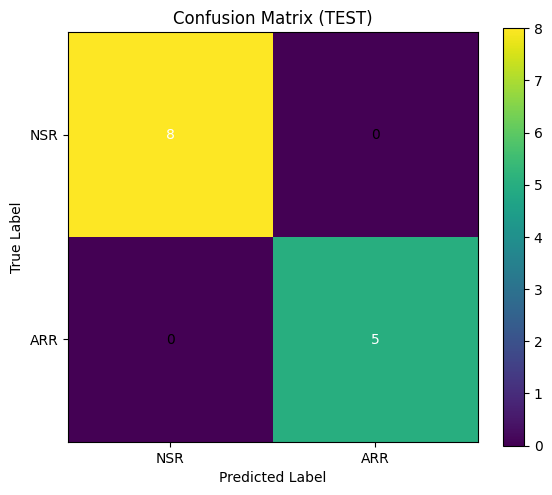

In [6]:
# =========================
# 8) Visual Confusion Matrix (Matplotlib)
# =========================
import matplotlib.pyplot as plt

class_names = ["NSR", "ARR"]

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation="nearest")  # no manual colors
plt.title("Confusion Matrix (TEST)")
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks, class_names)

# Write numbers inside boxes
thresh = cm.max() / 2.0 if cm.max() != 0 else 0.5
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, format(cm[i, j], "d"),
            horizontalalignment="center",
            verticalalignment="center",
            color="white" if cm[i, j] > thresh else "black"
        )

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


In [8]:
# ============================================================
# C) LOAD SAVED MODEL + MANUAL UPLOAD (ZIP) + PREDICT
#    Upload a .zip file that contains 10 images for ONE recording
# ============================================================

import os, zipfile
import numpy as np
import tensorflow as tf
from google.colab import files

MODEL_SAVE_PATH = "/content/drive/MyDrive/ECG_Images/small_2dcnn_lstm_arr_nsr.keras"
loaded_model = tf.keras.models.load_model(MODEL_SAVE_PATH)

print("Loaded model:")
loaded_model.summary()

print("\nUpload a ZIP containing 10 scalogram images (e.g., 0.png..9.png).")
uploaded = files.upload()  # upload zip

zip_name = list(uploaded.keys())[0]
extract_dir = "/content/manual_test_recording"
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_name, "r") as z:
    z.extractall(extract_dir)

# Collect images from extracted folder (search recursively)
img_paths = []
for root, dirs, files_ in os.walk(extract_dir):
    for f in files_:
        if f.lower().endswith((".png", ".jpg", ".jpeg")):
            img_paths.append(os.path.join(root, f))

# Sort by numeric stem (so 0..9)
def num_key(p):
    stem = os.path.splitext(os.path.basename(p))[0]
    m = re.findall(r"\d+", stem)
    return int(m[0]) if m else 10**9

img_paths.sort(key=num_key)

print("Found images:", len(img_paths))
print("First few:", img_paths[:3])

if len(img_paths) < SEQ_LEN:
    raise ValueError(f"Need at least {SEQ_LEN} images, but found {len(img_paths)}")

seq_paths = img_paths[:SEQ_LEN]  # take first 10

# Build a one-sample dataset (label is dummy here)
dummy_label = 0
ds_one = tf.data.Dataset.from_tensor_slices(([seq_paths], [dummy_label]))
ds_one = ds_one.map(load_sequence).batch(1)

prob = loaded_model.predict(ds_one, verbose=0)[0]
pred = int(np.argmax(prob))
conf = float(np.max(prob))

label_map = {0: "NSR", 1: "ARR"}
print("\n=== MANUAL UPLOAD PREDICTION ===")
print("Predicted class:", label_map[pred])
print("Confidence:", conf)
print("Probabilities [NSR, ARR]:", prob)


Loaded model:


Model: "Small_2DCNN_LSTM_ARR_NSR"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequence_input (InputLayer)     │ (None, 10, 227, 227,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_conv32 (TimeDistributed)     │ (None, 10, 227, 227,   │           896 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_bn1 (TimeDistributed)        │ (None, 10, 227, 227,   │           128 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_relu1 (TimeDistributed)      │ (None, 10, 227, 227,   │             0 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_pool1 (TimeDistributed)      │ (None, 10, 113, 113,   │             0 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_conv64 (TimeDistributed)     │ (None, 10, 113, 113,   │        18,496 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_bn2 (TimeDistributed)        │ (None, 10, 113, 113,   │           256 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_relu2 (TimeDistributed)      │ (None, 10, 113, 113,   │             0 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_pool2 (TimeDistributed)      │ (None, 10, 56, 56, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_conv128 (TimeDistributed)    │ (None, 10, 56, 56,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_bn3 (TimeDistributed)        │ (None, 10, 56, 56,     │           512 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_relu3 (TimeDistributed)      │ (None, 10, 56, 56,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_gap (TimeDistributed)        │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_out (Dense)             │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,808 (1.36 MB)

 Trainable params: 118,786 (464.01 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 237,574 (928.03 KB)


Upload a ZIP containing 10 scalogram images (e.g., 0.png..9.png).


Saving 234_MLII_segments.zip to 234_MLII_segments.zip
Found images: 10
First few: ['/content/manual_test_recording/234_MLII_segments/0.png', '/content/manual_test_recording/234_MLII_segments/1.png', '/content/manual_test_recording/234_MLII_segments/2.png']

=== MANUAL UPLOAD PREDICTION ===
Predicted class: ARR
Confidence: 0.7269790768623352
Probabilities [NSR, ARR]: [0.27302092 0.7269791 ]
